## Imports

In [2]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

## Set random seed for reproducibility

In [3]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Data Loading

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter


data_dir = "../data/balanced_data"


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in dataset.samples]


test_size = 0.1  
remaining_indices, test_indices = train_test_split(
    range(len(labels)),
    test_size=test_size,
    stratify=labels,
    random_state=SEED
)

test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


remaining_labels = [labels[i] for i in remaining_indices]
remaining_dataset = Subset(dataset, remaining_indices)


k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)




## Architecture Definition

In [ ]:

class ConformerTinyBinary(nn.Module):
    def __init__(self, img_size=128, num_classes=2, embed_dim=256, num_heads=8, num_transformer_layers=3, dropout=0.2):
        super(ConformerTinyBinary, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),  

            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),  

            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout)   
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.transformer(x)
        x = x.mean(dim=0)  
        x = self.fc(x)
        return x

## Function Definition

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from scipy import interp

model_dir = 'scratch_test_augmentless_kfold/saved_models'
os.makedirs(model_dir, exist_ok=True)


def save_model(epoch, model, optimizer, path, best=False):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)
    
        
        

def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
        y_true (array): True binary labels.
        y_pred (array): Predicted probabilities.
        min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
        float: Scaled pAUC value.
    """
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)

    
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc



def compute_auc_and_roc(model, dataloader, device, min_tpr=0.8):
    """
    Computes the ROC, AUC, and partial AUC for the given model and dataloader.
    
    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader for evaluation data.
        device: Device to run the computations on (CPU or GPU).
        min_tpr: Minimum TPR threshold for partial AUC computation.
    
    Returns:
        fpr: False positive rates.
        tpr: True positive rates.
        roc_auc: Full area under the ROC curve.
        partial_auc: Partial area under the ROC curve for TPR >= min_tpr.
        y_true: Ground truth labels.
        y_scores: Predicted scores for the positive class.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)  

    
    normalized_pauc = custom_metric(y_true, y_scores, min_tpr=min_tpr)

    return fpr, tpr, roc_auc, normalized_pauc, y_true, y_scores


## Model Init

In [7]:
# K-Fold Cross-Validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [8]:
learning_rate = 1e-4
batch_size = 64
num_epochs = 50

## Training

In [ ]:

fold_models = []  
fold_results = []  

train_accuracies_per_fold = []
val_accuracies_per_fold = []

for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(remaining_labels)), remaining_labels)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_indices = [remaining_indices[i] for i in train_indices]
    val_indices = [remaining_indices[i] for i in val_indices]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ConformerTinyBinary().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_path = os.path.join(model_dir, f"best_model_fold{fold + 1}.pth")

    train_accuracies = []
    val_accuracies = []
    train_losses = []  
    val_losses = []    

    for epoch in range(num_epochs):
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        _, train_acc = validate(model, train_loader, criterion, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(epoch, model, optimizer, best_model_path, best=True)

    
    train_accuracies_per_fold.append(train_accuracies)
    val_accuracies_per_fold.append(val_accuracies)

    
    fold_results.append({
        "fold": fold + 1,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "best_val_loss": best_val_loss
    })

    
    model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
    fold_models.append(model)  


## Testing

In [ ]:

fold_models = []
for fold in range(1, 6):  
    model_path = os.path.join(model_dir, f"best_model_fold{fold}.pth")
    model = ConformerTinyBinary().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  
    fold_models.append(model)
    print(f"Loaded model for Fold {fold} from {model_path}")
    

print("\nEvaluating on the test set with all fold models...")
test_predictions = np.zeros(len(test_dataset))  
test_true_labels = []  


for model in fold_models:
    model.eval()
    fold_test_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  
            fold_test_scores.extend(probabilities)

            
            if len(test_true_labels) < len(test_dataset):
                test_true_labels.extend(labels.cpu().numpy())

    
    fold_test_scores = np.array(fold_test_scores)

    if len(fold_test_scores) != len(test_dataset):
        raise ValueError(f"Model predictions length mismatch: expected {len(test_dataset)}, got {len(fold_test_scores)}")

    
    test_predictions += fold_test_scores


test_true_labels = np.array(test_true_labels)


test_predictions /= len(fold_models)

if len(test_true_labels) != len(test_predictions):
    raise ValueError("Mismatch between test labels and predictions!")


fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)
roc_auc = roc_auc_score(test_true_labels, test_predictions)


min_tpr = 0.8  
partial_auc = custom_metric(test_true_labels, test_predictions, min_tpr=min_tpr)

y_pred = (test_predictions >= 0.5).astype(int)  

print("\nFinal Classification Report:")
print(classification_report(test_true_labels, y_pred, target_names=dataset.classes))




c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\jonec\AppData\Local\Temp\ipykernel_56468\503910929.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lon

Loaded model for Fold 1 from scratch_test_augmentless_kfold/saved_models\best_model_fold1.pth
Loaded model for Fold 2 from scratch_test_augmentless_kfold/saved_models\best_model_fold2.pth
Loaded model for Fold 3 from scratch_test_augmentless_kfold/saved_models\best_model_fold3.pth
Loaded model for Fold 4 from scratch_test_augmentless_kfold/saved_models\best_model_fold4.pth
Loaded model for Fold 5 from scratch_test_augmentless_kfold/saved_models\best_model_fold5.pth

Evaluating on the test set with all fold models...


c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



Final Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        40
           1       0.79      0.79      0.79        39

    accuracy                           0.80        79
   macro avg       0.80      0.80      0.80        79
weighted avg       0.80      0.80      0.80        79



## Plotting

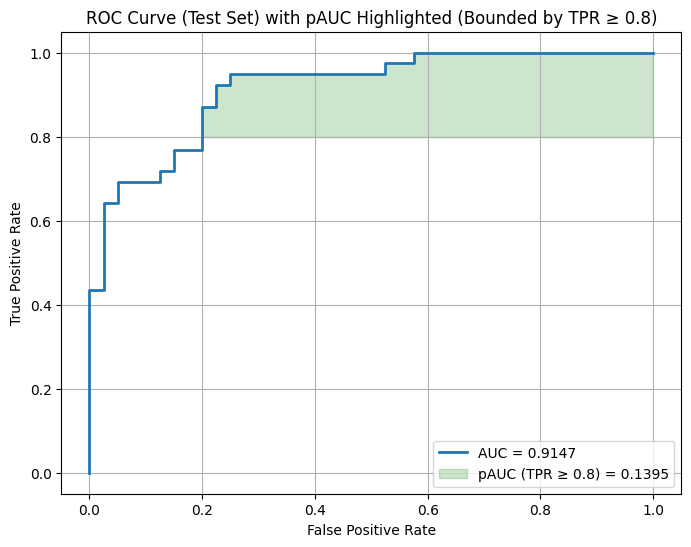

Saved ROC curve at scratch_test_augmentless_kfold/saved_models\ROC_curve_with_partial_AUC.png


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)


tpr_threshold = 0.8


fpr_interp = np.interp(tpr_threshold, tpr, fpr)


valid_indices = tpr >= tpr_threshold


fpr_bounded = np.concatenate(([fpr_interp], fpr[valid_indices]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[valid_indices]))


plt.fill_between(
    fpr_bounded,
    tpr_bounded,
    tpr_threshold,
    color="green",
    alpha=0.2,
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {partial_auc:.4f}"
)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set) with pAUC Highlighted (Bounded by TPR ≥ 0.8)")
plt.legend(loc="lower right")
plt.grid(True)


roc_curve_path = os.path.join(model_dir, "ROC_curve_with_partial_AUC.png")
plt.savefig(roc_curve_path, bbox_inches="tight")
plt.show()

print(f"Saved ROC curve at {roc_curve_path}")



In [ ]:
# Save model architecture and hyperparameters to a text file
params_file_path = os.path.join(model_dir, "model_params.txt")
with open(params_file_path, "w") as f:
    f.write("Model Architecture:\n")
    f.write(str(model) + "\n\n")  # Save the model architecture
    
    f.write("Hyperparameters:\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")
    
print(f"Model parameters and architecture saved to {params_file_path}")
